In [7]:
#import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from scipy.linalg import solve_continuous_are
import os
import math
import imageio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [8]:
#use seed for pytorch, numpy and random
seed = 40
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

#  Generate Dummy A,B,Q,R & Data

In [9]:
#Random A, B, Q, R (not parameters)
A = torch.randn(64, 64).float()
B = torch.randn(64, 64).float()
Q_base = torch.randn(64, 64).float()
R_base = torch.randn(64, 64).float()
Q = Q_base.t() @ Q_base
R = R_base.t() @ R_base #symmetric positive definite
#64 -> 8 Frozen Decoder
true_state_decoder = nn.Sequential(
    nn.Linear(64,16),
    nn.ReLU(),
    nn.Linear(16,8)
)
#Freeze decoder
for param in true_state_decoder.parameters():
    param.requires_grad = False
#8 -> 64 Frozen Encoder
true_state_encoder = nn.Sequential(
    nn.Linear(8,16),
    nn.ReLU(),
    nn.Linear(16,64)
)
#Freeze encoder
for param in true_state_encoder.parameters():
    param.requires_grad = False
true_action_decoder = nn.Sequential(
    nn.Linear(64,16),
    nn.ReLU(),
    nn.Linear(16,2)
)
true_action_encoder = nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,64)
)
#freeze
for param in true_action_decoder.parameters():
    param.requires_grad = False
for param in true_action_encoder.parameters():
    param.requires_grad = False
P = torch.tensor(solve_continuous_are(A, B, Q, R)).float()
K = -torch.inverse(R) @ B.t() @ P

#Use Ornstein-Uhlenbeck process to generate random states and actions
class OUProcess:
    def __init__(self, theta=0.15, sigma=0.2, x0=0.):
        self.theta = theta
        self.sigma = sigma
        self.x0 = x0
        self.reset()

    def reset(self):
        self.x_prev = self.x0

    def noise(self):
        x = self.x_prev + self.theta * (self.x0 - self.x_prev) + self.sigma * np.random.randn()
        self.x_prev = x
        return x

# Generate random states and actions using the OU process
def generate_data(ouprocess, num_samples):
    states = []
    actions = []
    ouprocess.reset()  # Reset the OU process before starting

    for i in range(num_samples):
        # Generate state and action using OU noise
        state = np.random.randn(8) + ouprocess.noise()  # Add OU noise to the state
        action = np.random.randn(2) + ouprocess.noise()  # Add OU noise to the action
        states.append(state)
        actions.append(action)

    return torch.tensor(states).float(), torch.tensor(actions).float()


random_states, random_actions = generate_data(OUProcess(), 1000)
#get all next states by encoding random states, using K, then decoding the states

encoded_random_states = true_state_encoder(random_states)
encoded_random_actions = true_action_encoder(random_actions)

#Use K to get next states
next_states = []
for i in range(len(random_states)):
    next_state = A @ encoded_random_states[i] + B @ encoded_random_actions[i]
    next_states.append(next_state)

#Decode next states
decoded_next_states = []
for i in range(len(next_states)):
    decoded_next_state = true_state_decoder(next_states[i])
    decoded_next_states.append(decoded_next_state)

#Add (S,A,S',SS) to dataloader
data = []
for i in range(len(random_states)):
    true_encoded_state = true_state_encoder(random_states[i])
    data.append((random_states[i], random_actions[i], decoded_next_states[i], true_encoded_state))

#Create dataloader
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

In [10]:
class LQRModel(nn.Module):
    def __init__(self, hidden_state_dim=64, hidden_action_dim=64, dropout_rate=0.3):
        super(LQRModel, self).__init__()

        self.state_encoder = nn.Sequential(
            nn.Linear(8, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU()
        )

        self.action_encoder = nn.Sequential(
            nn.Linear(2, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU()
        )

        self.state_decoder = nn.Sequential(
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, hidden_state_dim),
            nn.ReLU(),
            nn.Linear(hidden_state_dim, 8)
        )

        self.action_decoder = nn.Sequential(
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, hidden_action_dim),
            nn.ReLU(),
            nn.Linear(hidden_action_dim, 2)
        )

        # Initialize A with a stable base matrix + perturbation
        self.A_base = nn.Parameter(torch.randn(hidden_state_dim, hidden_state_dim) * 0.01)
        #self.A_diag = nn.Parameter(torch.ones(hidden_state_dim))  # Diagonal elements


        self.B = nn.Parameter(torch.randn(hidden_state_dim, hidden_action_dim) * 0.01)

        # Parameterize Q and R using Cholesky decomposition
        self.Q_base = nn.Parameter(torch.randn(hidden_state_dim, hidden_state_dim))
        self.R_base = nn.Parameter(torch.randn(hidden_action_dim, hidden_action_dim))

    def get_positive_semi_definite_matrix(self, base_matrix):
        return base_matrix.T @ base_matrix + torch.eye(base_matrix.size(0)) * 1e-6
#Input: Bx8 State, Bx2 Action
    def forward(self, state, action):
        batch_size = state.size(0)
        enc_state = self.state_encoder(state).unsqueeze(-1)
        enc_action = self.action_encoder(action).unsqueeze(-1)

        # Construct A as a perturbation of a stable matrix
        #A_stable = torch.diag(self.A_diag) + self.A_base  
        #A is a 64x64 matrix
        A_batch = self.A_base.unsqueeze(0).expand(batch_size, -1, -1)
        #A_batch is a Bx64x64 matrix
        # Add a small regularization term to the diagonal for numerical stability
        A_batch = A_batch + 1e-6 * torch.eye(self.A_base.size(0)).unsqueeze(0).expand(batch_size, -1, -1)

        B_batch = self.B.unsqueeze(0).expand(batch_size, -1, -1)


        x_dot_pred = torch.bmm(A_batch, enc_state) + torch.bmm(B_batch, enc_action)

        #Bx64x1 + Bx64x1 = Bx64x1
        

        x_prime = enc_state.squeeze(2) + x_dot_pred.squeeze(2)

        #x_prime = self.transition_nn_function(x_prime)

        #Bx64x1 -> Bx64
        Q = self.get_positive_semi_definite_matrix(self.Q_base) 
        R = self.get_positive_semi_definite_matrix(self.R_base)

        Q_batch = Q.unsqueeze(0).expand(batch_size, -1, -1)
        R_batch = R.unsqueeze(0).expand(batch_size, -1, -1)

        # Compute state_cost = state_enc^T Q state_enc
        state_cost = torch.bmm(enc_state.transpose(1, 2), torch.bmm(Q_batch, enc_state)).squeeze()

        # Compute action_cost = action_enc^T R action_enc
        action_cost = torch.bmm(enc_action.transpose(1, 2), torch.bmm(R_batch, enc_action)).squeeze()

        reward_pred = -(state_cost + action_cost)# + n_cost)

        return x_prime, reward_pred

In [11]:
hidden_state_dim = 64
hidden_action_dim = 64
model = LQRModel(hidden_state_dim=hidden_state_dim,hidden_action_dim=hidden_action_dim)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
epochs = 100000
losses = []
state_losses = []
enc_state_losses = []
decode_state_losses = []
criterion = nn.MSELoss()

for epoch in range(epochs):
    for i, (state, action, next_state, true_encoded_state) in enumerate(dataloader):
        optimizer.zero_grad()
        enc_next_state_pred, _ = model(state, action)
        state_loss = criterion(model.state_decoder(enc_next_state_pred), next_state)
        enc_state_loss = criterion(model.state_encoder(next_state), enc_next_state_pred)
        # print(state.shape)
        # print(model.state_decoder(true_encoded_state).shape)
        decode_state_loss = criterion(model.state_decoder(true_encoded_state), state)
        loss = state_loss + enc_state_loss + decode_state_loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        state_losses.append(state_loss.item())
        enc_state_losses.append(enc_state_loss.item())
        decode_state_losses.append(decode_state_loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Iteration {i}, Total Loss, {loss.item()}, State Loss {state_loss.item()}, Encoded State Loss {enc_state_loss.item()}, Decoded State Loss {decode_state_loss.item()}')

plt.plot(losses)
plt.plot(state_losses)
plt.plot(enc_state_losses)
plt.plot(decode_state_losses)
plt.legend(['Total Loss', 'State Loss', 'Encoded State Loss', 'Decoded State Loss'])
plt.show()
        

Epoch 0, Iteration 31, Total Loss, 1.6298832893371582, State Loss 0.44294247031211853, Encoded State Loss 0.004894868936389685, Decoded State Loss 1.1820459365844727
Epoch 1000, Iteration 31, Total Loss, 0.12150433659553528, State Loss 0.0012634563026949763, Encoded State Loss 0.00044453563168644905, Decoded State Loss 0.11979634314775467
Epoch 2000, Iteration 31, Total Loss, 0.0908631831407547, State Loss 0.0009665926336310804, Encoded State Loss 0.00030565273482352495, Decoded State Loss 0.08959093689918518
Epoch 3000, Iteration 31, Total Loss, 0.0656791627407074, State Loss 0.00039759426726959646, Encoded State Loss 0.0001442600623704493, Decoded State Loss 0.06513731181621552
Epoch 4000, Iteration 31, Total Loss, 0.053364213556051254, State Loss 0.0003146165399812162, Encoded State Loss 0.0002712990972213447, Decoded State Loss 0.052778296172618866
Epoch 5000, Iteration 31, Total Loss, 0.030618492513895035, State Loss 0.0004044179804623127, Encoded State Loss 0.0001581270043971017,

KeyboardInterrupt: 

In [13]:
#Save model and data
torch.save(model.state_dict(), 'model_dummy.pth')
torch.save(optimizer.state_dict(), 'optimizer_dummy.pth')
torch.save(data, 'data_dummy.pth')


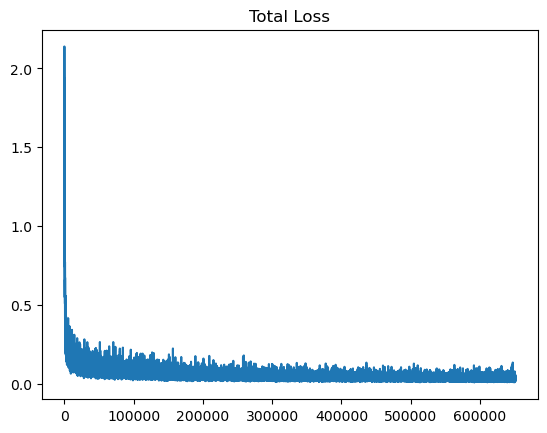

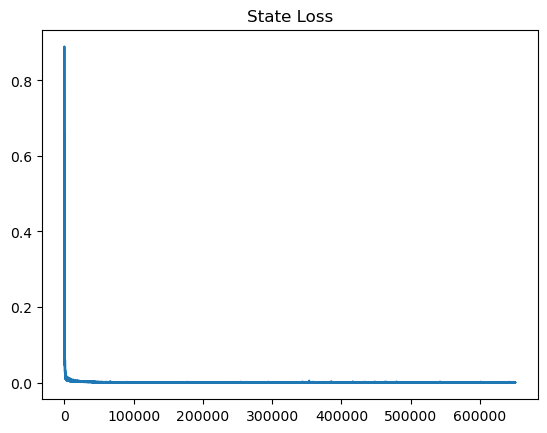

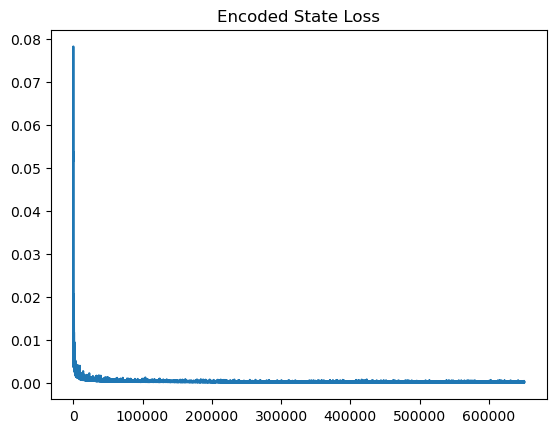

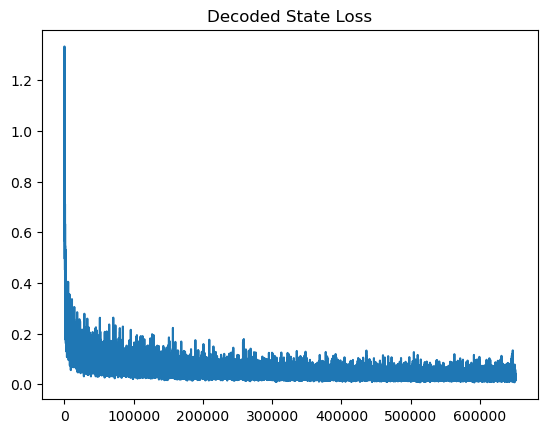

In [14]:
plt.plot(losses)
plt.title('Total Loss')
plt.show()
plt.plot(state_losses)
plt.title('State Loss')
plt.show()
plt.plot(enc_state_losses)
plt.title('Encoded State Loss')
plt.show()
plt.plot(decode_state_losses)
plt.title('Decoded State Loss')
plt.show()

In [15]:
learned_Q = model.get_positive_semi_definite_matrix(model.Q_base).detach().numpy()
learned_R = model.get_positive_semi_definite_matrix(model.R_base).detach().numpy()
learned_A = model.A_base.detach().numpy()
learned_B = model.B.detach().numpy()

learned_P = torch.tensor(solve_continuous_are(learned_A, learned_B, learned_Q, learned_R)).float()
learned_K = -torch.inverse(torch.tensor(learned_R).float()) @ torch.tensor(learned_B).float().T @ learned_P

In [16]:
#Difference between True K and Learned K
print(torch.norm(K - learned_K))
#check every linear combination of K and learned K
print(K.shape, learned_K.shape)

tensor(416.2696)
torch.Size([64, 64]) torch.Size([64, 64])


In [18]:
P_tilde = torch.randn_like(A).requires_grad_()
A_tilde = P.inverse() @ A @ P

# Find the most similar transformation P between A_learned and A_tilde
epochs = 100000
optimizer = optim.Adam([P_tilde], lr=0.01)
#MSE Criterion
criterion = nn.MSELoss()

In [19]:
learned_A_tensor = torch.tensor(learned_A).float().requires_grad_(False)

In [20]:
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()
    A_tilde = P_tilde.inverse() @ learned_A_tensor @ P_tilde
    loss = criterion(learned_A_tensor, A_tilde)
    loss.backward()
    optimizer.step()
    if epoch % 3000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

Epoch 0, Loss 2.3984551429748535
Epoch 3000, Loss 0.01643354445695877
Epoch 6000, Loss 0.006236694753170013
Epoch 9000, Loss 0.0026021101512014866
Epoch 12000, Loss 0.0009452553349547088
Epoch 15000, Loss 0.0003027786733582616
Epoch 18000, Loss 0.00013726152246817946
Epoch 21000, Loss 8.177525887731463e-05
Epoch 24000, Loss 6.242865492822602e-05
Epoch 27000, Loss 4.779474693350494e-05
Epoch 30000, Loss 3.737183942575939e-05
Epoch 33000, Loss 3.419312270125374e-05
Epoch 36000, Loss 2.891770054702647e-05
Epoch 39000, Loss 2.5407407520106062e-05
Epoch 42000, Loss 2.3457714632968418e-05
Epoch 45000, Loss 2.2123616872704588e-05
Epoch 48000, Loss 2.0480805687839165e-05
Epoch 51000, Loss 1.8793813069351017e-05
Epoch 54000, Loss 2.2358392016030848e-05
Epoch 57000, Loss 1.6627885997877456e-05
Epoch 60000, Loss 1.630051337997429e-05
Epoch 63000, Loss 1.654145489737857e-05
Epoch 66000, Loss 1.573569534230046e-05
Epoch 69000, Loss 1.4056897271075286e-05
Epoch 72000, Loss 1.3302553270477802e-05
Epo

In [21]:
PP_tilde = torch.randn_like(A).requires_grad_()
B_true = P.inverse() @ A @ P
fake_true_A = torch.randn_like(A).requires_grad_(False)
# Find the most similar transformation P between A_learned and A_tilde
epochs = 100000
optimizer = optim.Adam([PP_tilde], lr=0.01)
#MSE Criterion
criterion = nn.MSELoss()

In [22]:
epochs = 1000000
for epoch in range(epochs):
    optimizer.zero_grad()
    B_true = PP_tilde.inverse() @ fake_true_A @ PP_tilde
    loss = criterion(B_true, fake_true_A)
    loss.backward()
    optimizer.step()
    if epoch % 3000 == 0:
        print(f"Epoch {epoch}, Loss {loss.item()}")

Epoch 0, Loss 116.51961517333984
Epoch 3000, Loss 1.5847408771514893
Epoch 6000, Loss 0.7522417902946472
Epoch 9000, Loss 0.279315322637558
Epoch 12000, Loss 0.08331871032714844
Epoch 15000, Loss 0.024039093405008316
Epoch 18000, Loss 0.010752052068710327
Epoch 21000, Loss 0.0071111926808953285
Epoch 24000, Loss 0.005036001093685627
Epoch 27000, Loss 0.003993293736129999
Epoch 30000, Loss 0.002909197937697172
Epoch 33000, Loss 0.0025009755045175552
Epoch 36000, Loss 0.0019476190209388733
Epoch 39000, Loss 0.0016058662440627813
Epoch 42000, Loss 0.001191348535940051
Epoch 45000, Loss 0.0011783824302256107
Epoch 48000, Loss 0.001108978409320116
Epoch 51000, Loss 0.0008406254346482456
Epoch 54000, Loss 0.0009003719314932823
Epoch 57000, Loss 0.0006789285689592361
Epoch 60000, Loss 0.0007078483467921615
Epoch 63000, Loss 0.0007329359068535268
Epoch 66000, Loss 0.0006260905647650361
Epoch 69000, Loss 0.0006093668635003269
Epoch 72000, Loss 0.000537905958481133
Epoch 75000, Loss 0.0004932560

KeyboardInterrupt: 